In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import albumentations as A
import torch
from albumentations.pytorch import ToTensorV2
from sviro.dataset import SVIRODetection
from sviro.datamodule import collate_fn

from tools.inference import load_model, model_inference

from sviro.utils.image import draw_bounding_boxes

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
model_path = '../models/fasterrcnn_R50_fpn_x5_epoch50.ckpt'
dataset_path = '../data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
prediction_confidence_threshold = 0.5
eval_cars = ["aclass"]

In [4]:
transforms = A.Compose([
    ToTensorV2(),
])
 
dataset = SVIRODetection(
    dataroot=dataset_path,
    car=eval_cars,
    split='test',
    mapping={'infant_seat': 1},
    transform=transforms,
)

print(f"Dataset size: {len(dataset)}")

Dataset size: 250


In [5]:
model = load_model(model_path)
model.to(device)
model.eval()

DetectorModel(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            

In [6]:
test_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=4,
                                            shuffle=False,
                                            num_workers=4,
                                            pin_memory=True,
                                            drop_last=False,
                                            collate_fn=collate_fn)

    
   

   

In [7]:
stats, prediction, truth = model_inference(model,
                                           test_loader,
                                           prediction_confidence_threshold=prediction_confidence_threshold,
                                           device=device)

creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.638
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.638
 Average Recall     (AR) @[ IoU=0

In [8]:
loader = list(iter(test_loader))

In [9]:
batch_idx = 12
batch_images, batch_annot = loader[batch_idx]
preds = model.predict(batch_images, prediction_confidence_threshold=0.9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


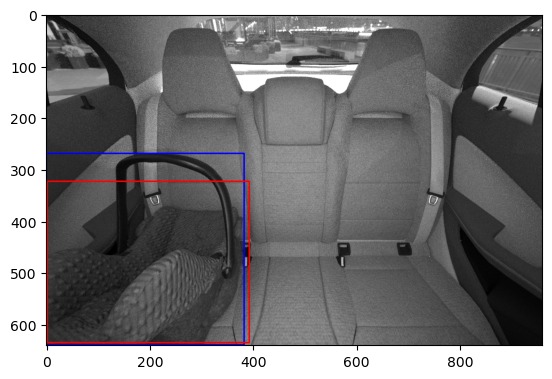

In [10]:
img_batch_idx = 3

image_id = batch_annot[img_batch_idx]['image_id'].item()
img =  test_loader.dataset[image_id][0].permute(1,2,0).numpy()
gt_boxes = test_loader.dataset[image_id][1]['boxes'].detach().cpu().numpy()
pred_boxes = preds['boxes'][img_batch_idx]

img_boxes = draw_bounding_boxes(img, gt_boxes, color=(0,0,255), thickness=2)
img_boxes = draw_bounding_boxes(img_boxes, pred_boxes, color=(255,0,0), thickness=2)

plt.imshow(img_boxes)